***Project description***

Our Beta Bank customers are leaving: little by little, chipping away every month. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones.

We need to predict whether a customer will leave the bank soon. You have the data on clients’ past behavior and termination of contracts with the bank.

In [35]:
#We will start by loading the fertilization we need for a classification task.
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from joblib import dump
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

In [36]:
#We will now load the data set.
df = pd.read_csv('/datasets/Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


**1.Preparation of the data set.**

Initial preparation:

In [37]:
#We will change the column names to lowercase.
df.columns= df.columns.str.lower()
df.head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [38]:
#Let's check if we have duplicates in the data set.
df.duplicated().sum()

0

No duplicates found.

In [39]:
#Let's see if we have any missing values.
pd.isnull(df).sum()

rownumber            0
customerid           0
surname              0
creditscore          0
geography            0
gender               0
age                  0
tenure             909
balance              0
numofproducts        0
hascrcard            0
isactivemember       0
estimatedsalary      0
exited               0
dtype: int64

In [40]:
#Let's check what percentage of our data is missing.
pd.isnull(df['tenure']).sum()/(len(df))*100 

9.09

9.9% of our 'tenure' column is missing.

In [41]:
#We will remove the missing values from our data set.
df.dropna(inplace=True)
pd.isnull(df).sum()

rownumber          0
customerid         0
surname            0
creditscore        0
geography          0
gender             0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0
isactivemember     0
estimatedsalary    0
exited             0
dtype: int64

Steps so far:

1.Make the names of the columns lowercase to make our job easier.

2.Duplicate check - not found.

3.Checking Missing Values - 909 missing values were found in column 'tenure', which constitute 9.9% of the column. The values were removed from the data set.

Feature Preparation:

In [42]:
#let's encoding our categoriel feature (using the OHE method)
categorical_columns = ['gender', 'geography', 'surname']
for column in categorical_columns:
    tempdf = pd.get_dummies(df[column], prefix=column)
    df = pd.merge(
        left=df,
        right=tempdf,
        left_index=True,
        right_index=True,
    )
    df = df.drop(columns=column)
print(df.head())

   rownumber  customerid  creditscore  age  tenure    balance  numofproducts  \
0          1    15634602          619   42     2.0       0.00              1   
1          2    15647311          608   41     1.0   83807.86              1   
2          3    15619304          502   42     8.0  159660.80              3   
3          4    15701354          699   39     1.0       0.00              2   
4          5    15737888          850   43     2.0  125510.82              1   

   hascrcard  isactivemember  estimatedsalary  ...  surname_Zinachukwudi  \
0          1               1        101348.88  ...                     0   
1          0               1        112542.58  ...                     0   
2          1               0        113931.57  ...                     0   
3          0               0         93826.63  ...                     0   
4          1               1         79084.10  ...                     0   

   surname_Zito  surname_Zotov  surname_Zotova  surname_Zox  s

In [43]:
#We will split our data set into a training set, a test set and an evaluation set.
# set aside 20% of train and test data for evaluation
df_train, df_test = train_test_split(df, test_size=0.2, random_state=12345)

# Use the same function above for the validation set
df_train, df_valid = train_test_split(df, test_size=0.25, random_state=12345) # 0.25 x 0.8 = 0.2

In [44]:
#We will now define features and targets for all of our data sets.
features_train = df_train.drop(['exited'], axis=1)
target_train = df_train['exited']

features_valid = df_valid.drop(['exited'], axis=1)
target_valid = df_valid['exited']

features_test = df_test.drop(['exited'], axis=1)
target_test = df_test['exited']

In [45]:
#let's scale the features using standardize the data.
numeric = ['estimatedsalary','creditscore','tenure','balance','numofproducts','hascrcard','isactivemember','age']
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Steps taken at this time:

-Transforming our categorical values into numerical values using the OHE method. I chose this method because I do not yet know which model I will use and since the variables are nominal.

-Splitting the data set into training, testing and evaluation sets.

-Set up features and targets for all our data sets.

-Standardization of our numerical features, so that the machine can estimate their range correctly.

**Our data is ready!**

**2.Examine the balance of classes. Train the model without taking into account the imbalance. Briefly describe your findings.**

In [46]:
#Let's start by finding the best model for our mission.
#Logistic regression:
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
model.score(features_valid, target_valid)
print(accuracy_score(target_valid, predictions_valid))
print("f1_score =", f1_score(target_valid, predictions_valid))

0.8015838099428069
f1_score = 0.0


In [47]:
#Decision tree classifier:
for depth in range(1, 6):
        model = DecisionTreeClassifier(random_state=12345, max_depth=depth)

        model.fit(features_train, target_train)

        predictions_valid = model.predict(features_valid)

        print("max_depth =", depth, ": ", end='')
        print(accuracy_score(target_valid, predictions_valid))
        print("f1_score =",f1_score(target_valid, predictions_valid))

max_depth = 1 : 0.8015838099428069
f1_score = 0.0
max_depth = 2 : 0.8407391113066432
f1_score = 0.5310880829015544
max_depth = 3 : 0.8424989001319841
f1_score = 0.39527027027027023
max_depth = 4 : 0.8574571051473823
f1_score = 0.543661971830986
max_depth = 5 : 0.8556973163220414
f1_score = 0.4858934169278997


Our most accurate model is a decision tree at depth 4, so we will continue with it.

In [48]:
#Let's examine the balance of classes.
#We eill train the model without taking into account the imbalance.
model = DecisionTreeClassifier(random_state=12345, max_depth=4)

model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)

print('Accuracy score:',accuracy_score(target_valid, predicted_valid))
print('Recall score:',recall_score(target_valid, predicted_valid))
print('Precision score:',precision_score(target_valid, predicted_valid))
print('F1 score:',f1_score(target_valid, predicted_valid))

Accuracy score: 0.8574571051473823
Recall score: 0.4279379157427938
Precision score: 0.7451737451737451
F1 score: 0.543661971830986


Findings:

Our recall score is below 0.5 which means we have more false negative than true positive answers.

Our precision score is higher than 0.5 and that means we have more true positive answers than false positive.

Our F1 index is lower than 0.59 so it is not enough to submit the project.

Conclusion - The classes are unbalanced, we will balance them to improve the indices.

**3.Improve the quality of the model.**

In [49]:
#Let's see if Class Weight Adjustment will improve our model balance.
model = DecisionTreeClassifier(random_state=12345, max_depth=4, class_weight='balanced')

model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)

print('Accuracy score:',accuracy_score(target_valid, predicted_valid))
print('Recall score:',recall_score(target_valid, predicted_valid))
print('Precision score:',precision_score(target_valid, predicted_valid))
print('F1 score:',f1_score(target_valid, predicted_valid))

Accuracy score: 0.7254729432468103
Recall score: 0.7716186252771619
Precision score: 0.4004602991944764
F1 score: 0.5272727272727272


Conclusion - This method raised my recall score, but hurt the rest of the metrics. We will not use it.

In [50]:
#Let's see if Upsampling method will improve our model balance.
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(
    features_train, target_train, 2
)

model = DecisionTreeClassifier(random_state=12345, max_depth=4)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print('Accuracy score:',accuracy_score(target_valid, predicted_valid))
print('Recall score:',recall_score(target_valid, predicted_valid))
print('Precision score:',precision_score(target_valid, predicted_valid))
print('F1 score:',f1_score(target_valid, predicted_valid))

Accuracy score: 0.8249010118785746
Recall score: 0.5698447893569845
Precision score: 0.5574837310195228
F1 score: 0.5635964912280702


I changed the parameter to 2. The F1 score has risen to 0.56, but it is still not enough. We will use this method and try another method to further improve the score.

Conclusion - This method raised me on the metrics, but lowered my recall.
Also our F1 score is not satisfactory yet.

In [61]:
model = DecisionTreeClassifier(random_state=12345, max_depth=4)
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_upsampled)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.4, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_upsampled, predicted_valid)
    recall = recall_score(target_upsampled, predicted_valid)
    f1 = f1_score(target_upsampled, predicted_valid)
    
    print('Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, f1 = {:.3f}'.format(threshold, precision, recall, f1))

print(" ")
print("Valid set:")

model = DecisionTreeClassifier(random_state=12345, max_depth=4)
model.fit(features_valid, target_valid)
probabilities_valid1 = model.predict_proba(features_valid)
probabilities_one_valid1 = probabilities_valid1[:, 1]

for threshold in np.arange(0, 0.4, 0.02):
    predicted_valid1 = probabilities_one_valid1 > threshold
    precision = precision_score(target_valid, predicted_valid1)
    recall = recall_score(target_valid, predicted_valid1)
    f1 = f1_score(target_valid, predicted_valid1)
    
    print('Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, f1 = {:.3f}'.format(threshold, precision, recall, f1))    

Threshold = 0.00 | Precision = 0.341, Recall = 1.000, f1 = 0.509
Threshold = 0.02 | Precision = 0.341, Recall = 1.000, f1 = 0.509
Threshold = 0.04 | Precision = 0.404, Recall = 0.980, f1 = 0.572
Threshold = 0.06 | Precision = 0.404, Recall = 0.980, f1 = 0.572
Threshold = 0.08 | Precision = 0.404, Recall = 0.980, f1 = 0.572
Threshold = 0.10 | Precision = 0.404, Recall = 0.980, f1 = 0.572
Threshold = 0.12 | Precision = 0.404, Recall = 0.980, f1 = 0.572
Threshold = 0.14 | Precision = 0.404, Recall = 0.980, f1 = 0.572
Threshold = 0.16 | Precision = 0.453, Recall = 0.924, f1 = 0.608
Threshold = 0.18 | Precision = 0.453, Recall = 0.924, f1 = 0.608
Threshold = 0.20 | Precision = 0.453, Recall = 0.924, f1 = 0.608
Threshold = 0.22 | Precision = 0.453, Recall = 0.924, f1 = 0.608
Threshold = 0.24 | Precision = 0.632, Recall = 0.707, f1 = 0.667
Threshold = 0.26 | Precision = 0.632, Recall = 0.707, f1 = 0.667
Threshold = 0.28 | Precision = 0.632, Recall = 0.707, f1 = 0.667
Threshold = 0.30 | Precis

According to the above test we conducted, the result seems to have risen very much and reached its highest score at Threshold = 0.38. We also reached a satisfactory F1 score.

On the vaild set we achive score of 0.565.

i fixed this.

We will now perform a final test on the test set and compare it with a score of auc_roc.

Threshold = 0.00 | Precision = 0.204, Recall = 1.000, f1 = 0.339
Threshold = 0.02 | Precision = 0.204, Recall = 1.000, f1 = 0.339
Threshold = 0.04 | Precision = 0.204, Recall = 1.000, f1 = 0.339
Threshold = 0.06 | Precision = 0.299, Recall = 0.921, f1 = 0.451
Threshold = 0.08 | Precision = 0.321, Recall = 0.902, f1 = 0.474
Threshold = 0.10 | Precision = 0.433, Recall = 0.827, f1 = 0.568
Threshold = 0.12 | Precision = 0.433, Recall = 0.827, f1 = 0.568
Threshold = 0.14 | Precision = 0.433, Recall = 0.827, f1 = 0.568
Threshold = 0.16 | Precision = 0.433, Recall = 0.827, f1 = 0.568
Threshold = 0.18 | Precision = 0.433, Recall = 0.827, f1 = 0.568
Threshold = 0.20 | Precision = 0.433, Recall = 0.827, f1 = 0.568
Threshold = 0.22 | Precision = 0.433, Recall = 0.827, f1 = 0.568
Threshold = 0.24 | Precision = 0.433, Recall = 0.827, f1 = 0.568
Threshold = 0.26 | Precision = 0.433, Recall = 0.827, f1 = 0.568
Threshold = 0.28 | Precision = 0.579, Recall = 0.599, f1 = 0.589


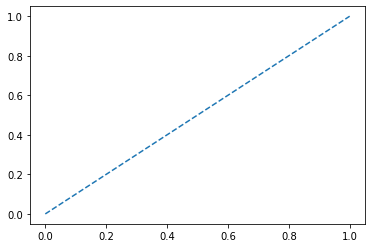

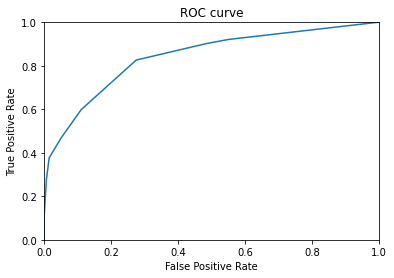

auc_roc score: 0.8413540790580321


In [60]:
model = DecisionTreeClassifier(random_state=12345, max_depth=4)
model.fit(features_test, target_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

for threshold in np.arange(0, 0.3, 0.02):
    predicted_test = probabilities_one_test > threshold
    precision = precision_score(target_test, predicted_test)
    recall = recall_score(target_test, predicted_test)
    f1 = f1_score(target_test, predicted_test)
    
    print('Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, f1 = {:.3f}'.format(threshold, precision, recall, f1))    
    
auc_roc = roc_auc_score(target_test, probabilities_one_test)

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()
print("auc_roc score:", auc_roc)

I adjusted all the parameters we learned in this sprint and used all the methods but the best result I got is 0.589 when the threshold is 0.28.

***final conculision***

We performed a final test on the test set.

Our final F1 result is 0.589.

We also performed an evaluation according to the RUC model.
Our score is 0.84 (0.34 above a random index) and this can also be seen on the above graphs where the upper graph indicates a random model and the lower our model.

Final conclusion - the model has almost exceeded the requirements and is ready for action.